# Exercise 6. Part 2. Generative adversarial networks

## Learning goals
* get familiar with measures of difference between two probability distributions
* get familiar with Generative Adversarial Networks

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import sys
import numpy as np
from scipy.stats import norm
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

from sklearn.neighbors import KernelDensity

In [4]:
# We'll run this exercise on CPU
device = torch.device('cpu')

## Synthetic data

Our training data will be sampled from a distribution that is a mixture of two Gaussian distributions:
$$
  p(x) = w_1 N(x \mid \mu_1, \sigma_1) + w_2 N(x \mid \mu_2, \sigma_2) .
$$
This will be the target distribution that we want to model with Generative Adversarial Networks.

The cell below defines the target probability distribution.

In [5]:
class MoG:
    def __init__(self, m=np.array([-0.5, 0.5]), w=[0.5, 0.5]):
        "Probability distribution which is a mixture of two Gaussians."
        self.w = w
        self.m = m
        self.sigma = np.array([0.2, 0.2])

    def logpdf(self, x):
        "Log-probability density function"
        w, m, sigma = self.w, self.m, self.sigma
        return np.logaddexp(
            np.log(w[0]) + norm.logpdf(x, loc=m[0], scale=sigma[0]),
            np.log(w[1]) + norm.logpdf(x, loc=m[1], scale=sigma[1])
        )

    def rvs(self, size):
        """Generate samples from the distribution.
        
        Args:
          size (int): Number of samples to generate.
        
        Returns:
          x (ndarray): Array of shape (size,) with generated samples.
        """
        x = norm.rvs(0, 1, size)
        z = (np.random.rand(size) <= 1-self.w[0]).astype(int)
        return x * self.sigma[z] + self.m[z]

In [6]:
# Let's generate training data from the target distribution
p_data = MoG()
n_samples = 100
data = p_data.rvs(n_samples)

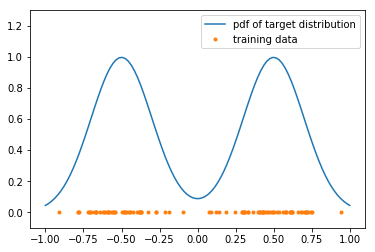

In [7]:
# Let's visualize generated samples
fig, ax = plt.subplots(1)
x = np.linspace(-1, 1, 100)
ax.plot(x, np.exp(p_data.logpdf(x)))
ax.plot(data, np.zeros_like(data), '.')
ax.set_ylim(-0.1, 1.3)
ax.legend(['pdf of target distribution', 'training data'])

## Generative adversarial networks

Our task is to train a generative model of the data, that is a model from which we can draw samples that will have a distribution similar to the distribution of the training data (shown in orange on the plot above).

### Generator
The generative model that we are going to train is:
\begin{align}
z &\sim N(0, I)
\\
x &= g(z)
\end{align}
that is the data is generated by applying a nonlinear transformation to samples drawn from the standard normal distribution.

We are going to model $g$ with a deep neural network created below.

In [58]:
class Generator(nn.Module):
    def __init__(self, latent_size=2):
        super(Generator, self).__init__()
        self.f = nn.Sequential(
            nn.Linear(latent_size, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )
    
    def forward(self, x):
        return self.f(x)

### Discriminator

The generative model will be guided by a discriminator whose task is to separate (classify) data into two classes:
* true data (samples from the training set)
* generated data (samples generated by the generator).

The task of the generator is to confuse the discriminator as much as possible, which is the case when the distribution produced by the generator perfectly replicates the data distribution.

We are going to use a deep neural network as the discriminator.

In [59]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.f = nn.Sequential(
            nn.Linear(1, 50),
            nn.LeakyReLU(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(0.2),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.f(x)

### Training GANs

In [60]:
latent_size = 2
G = Generator(latent_size)
D = Discriminator()

D = D.to(device)
G = G.to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

One iteration of our algorithm to train GANs is:
* Train the discriminator:
    * Generate fake data using the generator (generate the same number of samples as the
    number of real examples).
    * Use `criterion = nn.BCELoss()` defined below to compute the cost function.
    * Use all ones (`targets_real` defined below) as targets for the real data.
    * Use all zeroes (`targets_fake` defined below) as targets for the fake data.
    * Update the parameters of the discriminator using gradient descent.
* Train the generator:
    * Generate fake data using the generator
    * Update the parameters of the generator using gradient descent.

The update of the generator has already been implemented. Your task is to insert the part that updates the discriminator. You may also want to update the discriminator a few times for better convergence.

In [61]:
# Binary cross entropy loss
criterion = nn.BCELoss()
data_real = torch.Tensor(data).view(n_samples, 1).to(device)
targets_real = torch.ones(n_samples, 1).to(device)  # Targets for discriminator: real data
targets_fake = torch.zeros(n_samples, 1).to(device)  # Targets for discriminator: fake data

In [62]:
n_epochs = 1000  # You can increase the number of epochs if needed.

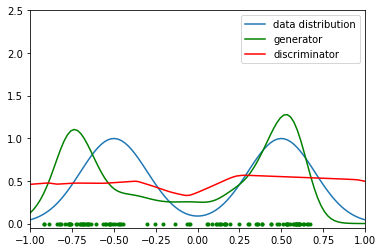

Epoch 996, g_loss: 0.7105


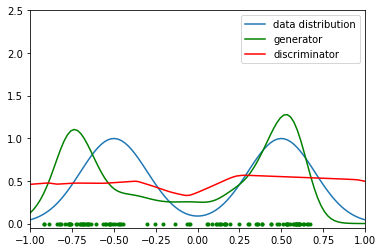

In [63]:
fig, ax = plt.subplots(1)  # Progress plot
scheduler = StepLR(g_optimizer, step_size=100, gamma=0.95)
for epoch in range(n_epochs):
    scheduler.step()
    # Train the discriminator
    # YOUR CODE HERE
    for j in range(1,11):
        z = torch.randn(n_samples, latent_size).to(device)
        data_fake = G(z)

        outputs_fake = D(data_fake)
        outputs_real = D(data_real)

        d_loss_fake = criterion(outputs_fake, targets_fake)
        d_loss_real = criterion(outputs_real, targets_real)

        d_optimizer.zero_grad()
        d_loss_fake.backward()
        d_loss_real.backward()
        d_optimizer.step()
    
    
    #raise NotImplementedError()

    # Train the generator
    # Compute loss with fake data
    z = torch.randn(n_samples, latent_size).to(device)
    data_fake = G(z)
    outputs = D(data_fake)
    g_loss = criterion(outputs, targets_real)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if skip_training:
        break

    if epoch % 4 == 0:
        # Plot progress
        ax.clear()

        # Plot probability density function of the target distribution
        x = np.linspace(-1, 1, 100)
        h1, = ax.plot(x, np.exp(p_data.logpdf(x)))

        # Plot estimate of the model pdf
        z = torch.randn(1000, latent_size).to(device)
        data_g = G(z)
        data_g = data_g.detach().cpu().numpy()
        kde = KernelDensity(kernel='gaussian', bandwidth=0.08).fit(data_g)
        log_pdf = kde.score_samples(x.reshape((-1, 1)))
        h2, = ax.plot(x, np.exp(log_pdf), 'g-')

        ax.plot(data_fake.detach().cpu().numpy(), np.zeros(n_samples), 'g.')

        d_output = D(torch.Tensor(x).view(-1, 1).to(device))
        h3, = ax.plot(x, d_output.detach().cpu().numpy(), 'r')

        ax.set_ylim([-0.05, 2.5])
        ax.set_xlim([-1, 1])
        ax.legend((h1, h2, h3), ('data distribution', 'generator', 'discriminator'),
                   loc='upper right')

        display.clear_output(wait=True)
        display.display(fig)
        
        print('Epoch {}, g_loss: {:.4f}'.format(epoch, g_loss.item()))

The generated data distribution should get close to the true data distribution.

In [56]:
# Save the model to disk, submit the files together with your notebook
g_filename = '6_gan_generator.pth'
d_filename = '6_gan_discriminator.pth'
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(G.state_dict(), g_filename)
            torch.save(D.state_dict(), d_filename)
            print('Model saved to %s, %s.' % (g_filename, d_filename))
        else:
            print('Model not saved.')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    G = Generator(latent_size)
    G.load_state_dict(torch.load(g_filename, map_location=lambda storage, loc: storage))
    print('Generator loaded from %s.' % g_filename)
    G = G.to(device)
    G.eval()

    D = Discriminator()
    D.load_state_dict(torch.load(d_filename, map_location=lambda storage, loc: storage))
    print('Discriminator loaded from %s.' % d_filename)
    D = D.to(device)
    D.eval()

Do you want to save the model (type yes to confirm)? yes
Model saved to 6_gan_generator.pth, 6_gan_discriminator.pth.


# Measures of difference between two probability distributions

According to the [original GAN paper](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), the GAN training procedure minimizes the Jensen–Shannon divergence (JSD) between the data distribution and the model distribution:
$$
\text{JSD}(p_\text{data} \:\lVert\: p_g) = \frac{1}{2} \left[\text{KL}(p_\text{data} \:\lVert\: p_*) + \text{KL}(p_g \:\lVert\: p_*) \right]
$$
where $p_*(x) = \frac{1}{2} \left[p_\text{data}(x) + p_g(x)\right]$
and $\text{KL}(p \:\lVert\: q)$ is the Kullback-Leibler divergence defined as
$$
  \text{KL}(p \:\lVert\: q) = \int p(x) \log \frac{p(x)}{q(x)} dx \,.
$$

We are going to track the JSD during training. In order to do that, we need to estimate the KL-divergence between two distributions, which can be done via sampling:
$$
KL(p \:\lVert\: q) \approx \frac{1}{N} \sum_{i=1}^N \left[ -\log q(x_i) + \log p(x_i) \right]
\qquad \text{with} \quad x_i \sim p(x)
$$

In the cell below, your task is to implement a function that estimates the Kullback-Leibler divergence for two given distributions.

In [64]:
def KL(p, q, n=10000):
    """Estimate of the Kullback-Leibler divergence between distributions p and q.
       KL(p || q) = - \int p(x) \log q(x) dx + \int p(x) \log p(x) dx
    
    Args:
      p and q are objects with the following methods:
        p.logpdf(x): Computes log-probability density function for numpy arrays x
        p.rvs(n): Draws n random samples from the distribution (returns a numpy array)
        See class MoG for an example distribution.
      n (int): Number of samples to be drawn from p.
    
    Returns:
      Estimate of the Kullback-Leibler divergence between distributions p and q.
    """
    # YOUR CODE HERE
    
    p_samples = p.rvs(n)
    q_samples = q.rvs(n)
    KL = (np.sum(- q.logpdf(q_samples) + p.logpdf(p_samples)))/n
    return KL
    
    #raise NotImplementedError()

In [65]:
class Gaussian:
    def __init__(self, m, sigma):
        self.m, self.sigma = m, sigma

    def logpdf(self, x):
        return norm.logpdf(x, self.m, self.sigma)

    def entropy(self):
        return norm.entropy(self.m, self.sigma)

    def rvs(self, size):
        return norm.rvs(self.m, self.sigma, size)

p1 = Gaussian(0, 1)
p2 = Gaussian(0.5, 1)
print(KL(p1, p2, n=1000))

0.00582179298999


In [66]:
# Jensen–Shannon divergence
class AveragePDFDistribution:
    def __init__(self, p1, p2):
        """Distribution whose pdf is an average the pdfs of two given distributions:
            p(x) = 0.5 (p1(x) + p2(x))
        """
        self.p1 = p1
        self.p2 = p2

    def logpdf(self, x):
        return np.logaddexp(self.p1.logpdf(x), self.p2.logpdf(x)) + np.log(0.5)

    def rvs(self, n):
        return np.hstack((self.p1.rvs(n//2), self.p2.rvs(n//2)))


def JSD(p1, p2, n=10000):
    """Jensen–Shannon divergence
        JSD = 0.5 (KL(p1 || 0.5 (p1 + p2)) + KL(p2 || 0.5 (p1 + p2)))
    """
    average_dist = AveragePDFDistribution(p1, p2)
    return 0.5 * (KL(p1, average_dist, n) + KL(p2, average_dist, n))

In [67]:
# This is the model distribution
class GeneratorDistribution:
    def __init__(self, G, latent_size):
        """Distribution modeled by the generator."""
        self.G = G
        self.latent_size = latent_size
        self.kde = None

    def fit(self):
        # Fit kernel density estimator
        data_g = self.rvs(1000)
        self.kde = KernelDensity(kernel='gaussian', bandwidth=0.08).fit(data_g[:, None])

    def logpdf(self, x):
        log_pdf_x = self.kde.score_samples(x.reshape((-1, 1)))
        return log_pdf_x

    def rvs(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).to(device)
            data_g = self.G(z).view(-1)
        return data_g.cpu().numpy()

In [68]:
# Train GANs again
G = Generator(latent_size)
D = Discriminator()

D = D.to(device)
G = G.to(device)
# This is the model distribution
model_dist = GeneratorDistribution(G, latent_size)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [69]:
n_epochs = 1000

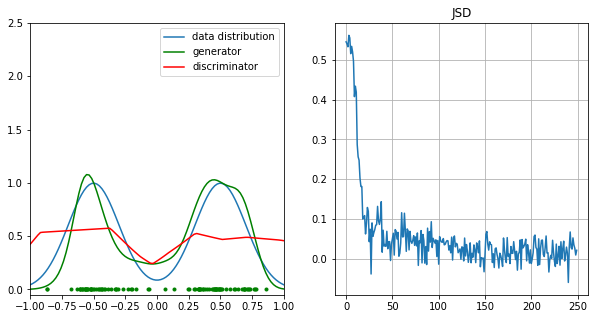

Epoch 996, g_loss: 0.6915, jsd: 0.0212


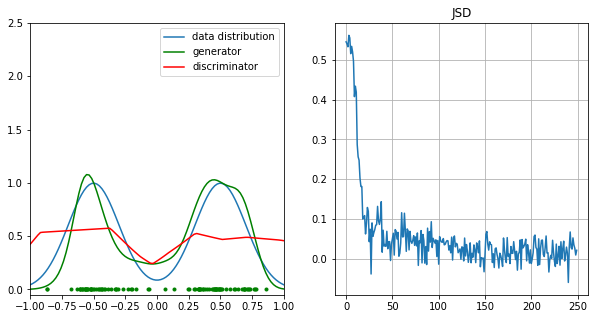

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Progress plot
scheduler = StepLR(g_optimizer, step_size=100, gamma=0.95)
jsd_history = []
for epoch in range(n_epochs):
    scheduler.step()
    # Train the discriminator
    # Copy your code that updates the discriminator here
    # YOUR CODE HERE
    for j in range(1,11):
        z = torch.randn(n_samples, latent_size).to(device)
        data_fake = G(z)

        outputs_fake = D(data_fake)
        outputs_real = D(data_real)

        d_loss_fake = criterion(outputs_fake, targets_fake)
        d_loss_real = criterion(outputs_real, targets_real)

        d_optimizer.zero_grad()
        d_loss_fake.backward()
        d_loss_real.backward()
        d_optimizer.step()
    
    
    #raise NotImplementedError()

    # Train the generator
    # Compute loss with fake data
    z = torch.randn(n_samples, latent_size).to(device)
    data_fake = G(z)
    outputs = D(data_fake)
    g_loss = criterion(outputs, targets_real)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if skip_training:
        break

    if epoch % 4 == 0:
        model_dist.fit()
        try:
            jsd_history.append(JSD(p_data, model_dist, n=500))
        except:
            jsd_history.append(np.NaN)

        # Plot progress
        ax = axs[0]
        ax.clear()

        # Plot probability density function of the target distribution
        x = np.linspace(-1, 1, 100)
        h1, = ax.plot(x, np.exp(p_data.logpdf(x)))

        # Plot estimate of the model pdf
        log_pdf = model_dist.logpdf(x)
        h2, = ax.plot(x, np.exp(log_pdf), 'g-')

        ax.plot(data_fake.detach().cpu().numpy(), np.zeros(n_samples), 'g.')

        d_output = D(torch.Tensor(x).view(-1, 1).to(device))
        h3, = ax.plot(x, d_output.detach().cpu().numpy(), 'r')

        ax.set_ylim([-0.05, 2.5])
        ax.set_xlim([-1, 1])
        ax.legend((h1, h2, h3), ('data distribution', 'generator', 'discriminator'),
                   loc='upper right')

        ax = axs[1]
        ax.clear()
        ax.plot(jsd_history)
        ax.grid(True)
        ax.set_title('JSD')
        display.clear_output(wait=True)
        display.display(fig)
        
        print('Epoch {}, g_loss: {:.4f}, jsd: {:.4f}'.format(
            epoch, g_loss.item(), jsd_history[-1]))

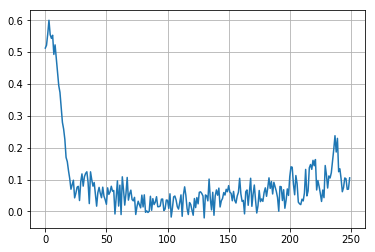

In [57]:
plt.plot(jsd_history)
plt.grid(True)